In [94]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from matplotlib import pyplot as plt

In [163]:
from datasets import load_dataset
tiny_imagenet = load_dataset('Maysee/tiny-imagenet', split='train')
tiny_imagenet.save_to_disk("tiny_imagenet_train")

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

AttributeError: module 'PIL.Image' has no attribute 'ExifTags'

In [79]:
with open('zerotohero/tinyshakespeare.txt', 'r', encoding='utf-8') as f:
    texts = f.read()

chars = sorted(list(set(texts)))
vocab_size = len(chars)
stoi = { ch : i for i, ch in enumerate(chars)}
itos = { i : ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[e] for e in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [80]:
# prep data

data = torch.tensor(encode(texts), dtype=torch.long)
n = int(0.9 * len(data))
train = data[:n]
eval = data[n:]

block_size = 8
data[:100]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])

In [81]:
def get_batch(split):
    if split == 'train':
        data = train
    else:
        data = eval
    ix = torch.randint(len(data) - block_size, (32,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    return x, y

bx, by = get_batch('train')

In [82]:
eval_iters = 10
def estimate_loss():
    out = {}
    m.eval() # eval mode does not track grad so it's fast
    for split in ['train', 'eval']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            _, loss = m(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out
        


In [95]:
head_size = 8
n_embd = vocab_size

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.k = nn.Linear(n_embd, head_size, bias=False)
        self.q = nn.Linear(n_embd, head_size, bias=False)
        self.v = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape

        k = self.k(x) # B T head_size
        q = self.q(x) # B T head_size
        wei = k @ torch.transpose(q, -2, -1) * C**-0.5  # -> B T T
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei,  dim=-1)

        v = self.v(x) # B T head_size
        out = wei @ v # B T C
        return out

class Bigram(nn.Module):
    def __init__(self):
        super().__init__()
        self.embd = nn.Embedding(vocab_size, n_embd) # C C 
        self.pos = nn.Embedding(block_size, n_embd)
        self.head = Head(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        embd_tokens = self.embd(idx) # B T C
        pos_tokens = self.pos(torch.arange(T)) # T, C
        x = embd_tokens + pos_tokens # B T C
        x = self.head(x)

        logits = self.lm_head(x) # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss


In [89]:
lr = 1e-3
max_iter = 1000
m = Bigram()

optimizer = torch.optim.AdamW(m.parameters(), lr=lr)

stepsi = []
train_losses = []
eval_losses = []

for step in range(max_iter):
    if step % 100 == 0:
        stepsi.append(step)
        losses = estimate_loss()
        train_losses.append(losses['train'])
        eval_losses.append(losses['eval'])
    x, y = get_batch('train')
    logits, loss = m(x, y)

    optimizer.zero_grad(set_to_none=True)
    # for p in m.parameters():
    #     p.grad = None
    loss.backward()

    # for p in m.parameters():
    #     p.data += -0.5 * p.grad
    optimizer.step()


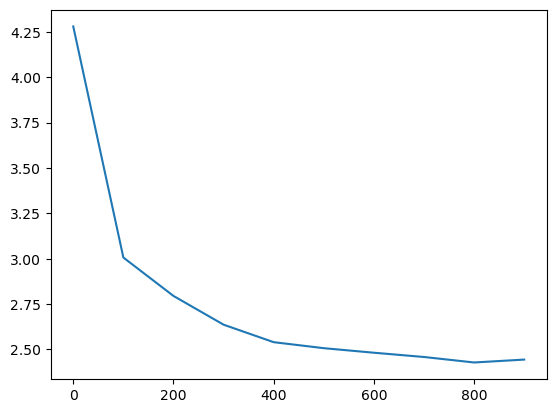

In [92]:
plt.plot(stepsi, train_losses)

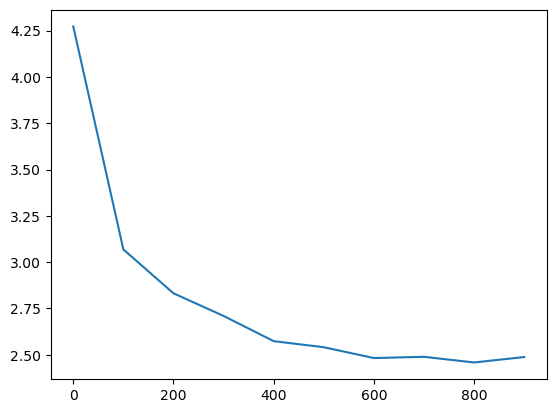

In [93]:
plt.plot(stepsi, eval_losses)